In [1]:
# testing out CNN

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import wfdb
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pywt
import funcs

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
path = "pickled/"
trainReadings = funcs.unpickler(path + 'train_readings.pkl')
trainDiagnostic = funcs.unpickler(path + 'train_diagnostic.pkl')
validateReadings = funcs.unpickler(path + 'validate_readings.pkl')
validateDiagnostic = funcs.unpickler(path + 'validate_diagnostic.pkl')
testReadings = funcs.unpickler(path + 'test_readings.pkl')
testDiagnostic = funcs.unpickler(path + 'test_diagnostic.pkl')

oneHotTrain = funcs.one_hot_encoder(trainDiagnostic, 2)
oneHotValidate = funcs.one_hot_encoder(validateDiagnostic, 2)
oneHotTest = funcs.one_hot_encoder(testDiagnostic, 2)

In [6]:
# data is imbalanced so we balance it

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(trainDiagnostic),
                                        y = trainDiagnostic                                                    
                                    )
class_weights = dict(zip(np.unique(trainDiagnostic), class_weights))

In [7]:
def make_for_cnn(data, scale):
    transform = []
    for i in data:
        transform.append(pywt.cwt(i, scales, 'mexh')[0].T)
    return np.array(transform)

In [8]:
scales = np.linspace(0.1, 1, 10) # scales to use for cwt

trainTransform = make_for_cnn(trainReadings, scales)
validateTransform = make_for_cnn(validateReadings, scales)
testTransform = make_for_cnn(testReadings, scales)

trainTransform.shape

(10977, 1000, 10)

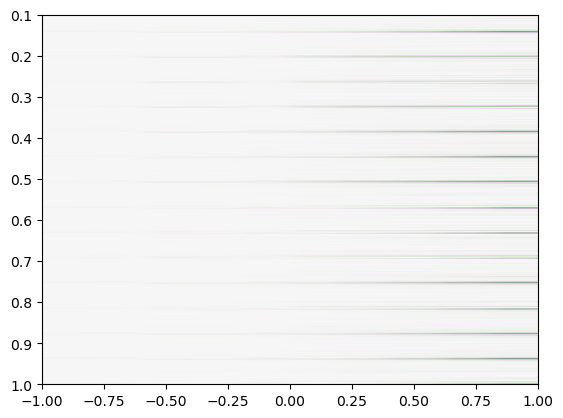

In [9]:
plt.imshow(trainTransform[0], extent=[-1, 1, 1, 0.1], cmap='PRGn', aspect='auto',
           vmax=abs(trainTransform[0]).max(), vmin=-abs(trainTransform[0]).max())

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Conv1D
from keras import metrics

In [11]:
inputShape = (32, 1000, len(scales))

In [12]:
inputShape

(32, 1000, 10)

In [27]:
#should we try using a rectangular kernel size?
model = Sequential()
convLayer = Conv1D(
    filters=64, kernel_size=10, input_shape=inputShape[1:], data_format="channels_last", activation='relu')

model.add(convLayer)
#what should the final value in the input be
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 991, 64)           6464      
                                                                 
 flatten_2 (Flatten)         (None, 63424)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                3171250   
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 2)                 102       
                                                                 
Total params: 3,180,366
Trainable params: 3,180,366
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(
    optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), 
 metrics=['accuracy',tf.keras.metrics.FalsePositives()])

In [30]:
class_weights

{0: 0.5447102024612942, 1: 6.091564927857935}

In [31]:
model.fit(
    trainTransform, oneHotTrain, 
    epochs=10, 
    class_weight=class_weights, 
        validation_data=(validateTransform, oneHotValidate))

Epoch 1/10
344/344 [==============================] - 8s 23ms/step - loss: 0.6895 - accuracy: 0.5816 - false_positives_2: 4593.0000 - val_loss: 0.6503 - val_accuracy: 0.5567 - val_false_positives_2: 1622.0000
Epoch 2/10
344/344 [==============================] - 8s 22ms/step - loss: 0.6133 - accuracy: 0.6106 - false_positives_2: 4274.0000 - val_loss: 0.5006 - val_accuracy: 0.7177 - val_false_positives_2: 1033.0000
Epoch 3/10
344/344 [==============================] - 7s 21ms/step - loss: 0.4297 - accuracy: 0.7675 - false_positives_2: 2552.0000 - val_loss: 0.5346 - val_accuracy: 0.7180 - val_false_positives_2: 1032.0000
Epoch 4/10
344/344 [==============================] - 7s 20ms/step - loss: 0.2430 - accuracy: 0.8815 - false_positives_2: 1301.0000 - val_loss: 0.4704 - val_accuracy: 0.8032 - val_false_positives_2: 720.0000
Epoch 5/10
344/344 [==============================] - 7s 20ms/step - loss: 0.1078 - accuracy: 0.9498 - false_positives_2: 551.0000 - val_loss: 0.4797 - val_accuracy:

In [23]:
model.evaluate(testTransform, oneHotTest)

115/115 [==============================] - 1s 5ms/step - loss: 1.4705 - accuracy: 0.9087 - false_positives_1: 334.0000


[1.4704995155334473, 0.908743143081665, 334.0]

In [25]:
funcs.evaluate_model(model.predict(testTransform), oneHotTest)

115/115 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      3353
           1       0.42      0.24      0.31       307

   micro avg       0.91      0.91      0.91      3660
   macro avg       0.68      0.61      0.63      3660
weighted avg       0.89      0.91      0.90      3660
 samples avg       0.91      0.91      0.91      3660

